# Lab — (Sub)Graph  embedding

Previously we have studied the graph neural networks that allow us to obtain node embeddings. However, there are several (sub)graph-level tasks, e.g. molecular property prediction. To solve it, we should be able to receive full graph embedding. This seminar concentrates on several graph pooling techniques.


In [1]:
! pip install ogb
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 7.6 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=2a817388f73072dbe230a5857f5264dd6c35f97cf5b8cf7395de23f9cd1c1fea
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 269.3 MB 10 kB/s 
     |████████████████████████████████| 281 kB 36.1 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [2]:
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from ogb.graphproppred import DglGraphPropPredDataset, collate_dgl, Evaluator
import numpy as np

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


## Dataset description

We will experiment with the [Graph Property Prediction dataset](https://ogb.stanford.edu/docs/graphprop/), more precisely with `ogbg-molhiv`.
The dataset contains several graphs adopted from [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a), each graph represents the molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

In the next cell we load dataset from `ogb` library, split it into train, validation and test subsets and create pytorch dataloaders.

In [3]:
dataset = DglGraphPropPredDataset(name="ogbg-molhiv")

split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, collate_fn=collate_dgl)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, collate_fn=collate_dgl)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, collate_fn=collate_dgl)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 91435.86it/s]


Converting graphs into DGL objects...


100%|██████████| 41127/41127 [00:09<00:00, 4468.48it/s]


Saving...


In [4]:
import networkx as nx

labels = dataset.labels.detach().cpu().numpy()
pos = np.where(labels)[0]  # choose positive labels

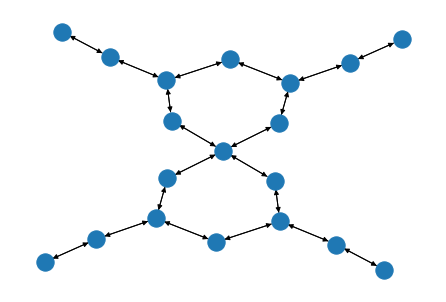

In [5]:
nx.draw_kamada_kawai(dataset.graphs[0].to_networkx())

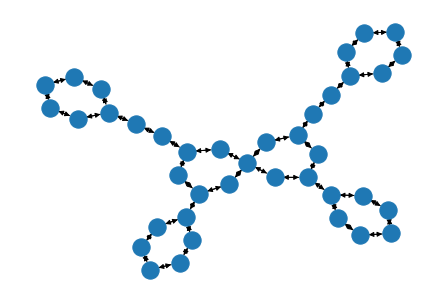

In [6]:
nx.draw_kamada_kawai(dataset.graphs[1].to_networkx())

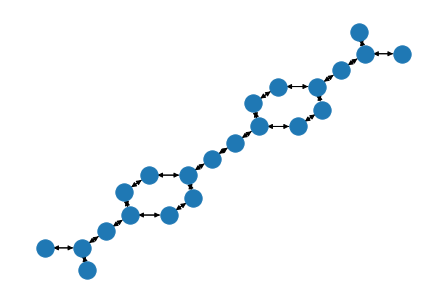

In [7]:
nx.draw_kamada_kawai(dataset.graphs[pos[0]].to_networkx())

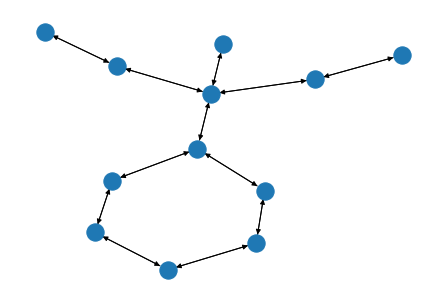

In [8]:
nx.draw_kamada_kawai(dataset.graphs[pos[1]].to_networkx())

## DGL for multiple graphs

Previously, we have used DGL to work with one graph. However, it is also suitable for working in multiple graphs scenario.

DataLoader encodes multiple graphs as one large graph. Nodes of it each graph are grouped. To reconstruct whether the specific graph is, we can use `graph.batch_num_nodes()`. This function will return tensor with number of nodes in each graph.

For example, in the next cell we will extract the first element from the `train_loader`.

In [9]:
graphs, labels = train_loader.__iter__().__next__()
graphs, labels

(Graph(num_nodes=817, num_edges=1746,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]))

Now, we can extract number of nodes in each graph.

In [10]:
graphs.batch_num_nodes()

tensor([29, 29, 25, 23, 19, 22, 16, 30, 18, 25, 34, 28, 31, 24, 17, 23, 14, 22,
        23, 19, 22, 24, 58, 34, 34, 22, 23, 20, 20, 23, 36, 30])

From that we can reconstruct the graph indicator and manually aggregate data over it. However DGL has several predefined functions for this case: `dgl.sum_nodes`, `dgl.mean_nodes`, `dgl.max_nodes`, `dgl.min_nodes`. These functions have similar signatures, e.g., `dgl.sum_nodes(graph, "feat")`. The second parameter aggregates the attribute name in `graph.ndata` which is a dictionary that contains node-level properties as a `torch.tensor` for all vertices. You can assign any value here. It is usefull when we use message-passing approach to pass the hidden features.

For example, let us check what data it currently contains

In [11]:
graphs.ndata['feat']

tensor([[ 5,  0,  4,  ...,  2,  0,  0],
        [ 5,  0,  4,  ...,  2,  0,  0],
        [ 7,  0,  2,  ...,  1,  0,  0],
        ...,
        [ 5,  0,  3,  ...,  1,  1,  1],
        [ 5,  0,  3,  ...,  1,  0,  1],
        [15,  0,  1,  ...,  1,  0,  0]])

In [12]:
graphs.ndata['feat'].shape

torch.Size([817, 9])

Currently, graph has only default features under the `"feat"` parameter. The pooling functions works only with float features but `"feat"` are categorical (Long) labels. For demostration purpose we can convert it to `torch.FloatTensor` and assign to the new field named `"float_feat"`.

In [13]:
graphs.ndata["float_feat"] = graphs.ndata["feat"].to(torch.float32)

Now, we are able to aggregate graph features

In [14]:
mean = dgl.mean_nodes(graphs, "float_feat")
mean

tensor([[5.2414, 0.0000, 3.0000, 5.0000, 0.7931, 0.0000, 1.1724, 0.6207, 0.8276],
        [5.4828, 0.0000, 3.3103, 5.0000, 1.1724, 0.0000, 1.7586, 0.0000, 0.4828],
        [5.1200, 0.0000, 2.9200, 5.0000, 0.6000, 0.0000, 1.0000, 1.0000, 1.0000],
        [6.5652, 0.0000, 2.6957, 5.0000, 0.4348, 0.0000, 1.0435, 0.8696, 0.8696],
        [6.6842, 0.0000, 2.6316, 5.0000, 0.5263, 0.0000, 0.9474, 0.6316, 0.6316],
        [5.4091, 0.0000, 2.6818, 5.0000, 0.5000, 0.0000, 1.0000, 0.6818, 0.6818],
        [5.5000, 0.0000, 3.1250, 5.0000, 1.0000, 0.0000, 1.4375, 0.3125, 0.5000],
        [5.8000, 0.0000, 3.0667, 5.0000, 0.8667, 0.0000, 1.5667, 0.4000, 0.6667],
        [6.0556, 0.0000, 2.7222, 5.0000, 0.6111, 0.0000, 1.1667, 0.5556, 0.5556],
        [6.2400, 0.0000, 2.9200, 5.0000, 0.8400, 0.0000, 1.3600, 0.3600, 0.3600],
        [5.2353, 0.0000, 3.4118, 5.0000, 1.2353, 0.0000, 1.6176, 0.0000, 0.5000],
        [5.8214, 0.0000, 3.3929, 5.0000, 1.5357, 0.0000, 1.8571, 0.0000, 0.0000],
        [5.7097,

Let us check that number of lines is equal to the number of graphs in the batch

In [15]:
assert mean.size(0) == train_loader.batch_size

### Sum, mean and max pooling

Previously, we have studied GNNs. To receive node embeddings, usually, one use some operator that aggregates adjacent node embeddings. We can use similar approach for the whole graphs. In the task, we will implement the classic methods of graph-level pooling with further prediction of graph class, e.g, whether a molecule inhibits HIV virus replication or no.

In [17]:
class SimplePooling(nn.Module):
  def __init__(self, atom_dim=8, out_dim=1, pooling_func='sum'):
    """
    Simple neural network that encodes atoms, pool it with sum, max or mean aggregation.
    In the task you need to instantiate AtomEncoder, pooling function
    and projection (fully-connected) layer from embedding dimension to output dimension

    :param atom_dim: dimension of atom embedding for AtomEncoder (int)
    :param out_dim: dimension of output (int)
    :param pooling_func: name of pooling function (str)
                         could be one of 'sum', 'mean' or 'max'.
                         You need to use proper aggregation function described above
    """
    super(SimplePooling, self).__init__()
    self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
    self.pooling_func = getattr(dgl, f"{pooling_func}_nodes")
    self.fc = nn.Linear(atom_dim, out_dim)
  
  def forward(self, graph):
    """
    Encodes the atom in the graph, pool vertices over graphs and predict the target

    :param graph: dgl graph with batch of graphs
    """
    graph.ndata['h'] = self.atom_encoder(graph.ndata["feat"])
    return self.fc(self.pooling_func(graph, 'h'))

We are trying to solve classification task, so we can use the binary cross-entropy loss.

In [18]:
criterion = nn.BCEWithLogitsLoss()

Let us define the `train` method. It iterates over batches and for each batch do the following:
1. calculates forward pass with model
2. moves to zero the gradient of previous step in optimizer
3. calculates the loss according to the criterion
4. backwards the loss
5. does optimization step

In [19]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

def train(model, loader, optimizer):
  """
  Train loop for model. Do not forget to switch model to train mode and place all tensors to device

  :param model: neural net that we want to train
  :param loader: data loader
  :param optimizer: optimizer for given network
  """
  model.train()
  for batch, label in tqdm(loader):
    batch = batch.to(device)
    batch.ndata['feat'] = batch.ndata['feat'].to(device)
    batch.edata['feat'] = batch.edata['feat'].to(device)
    label = label.to(device)
    logits = model(batch)
    optimizer.zero_grad()
    loss = criterion(logits.to(torch.float32), label.to(torch.float32))
    loss.backward()
    optimizer.step()

We also need the evaluation method, which will return the metrics for the task. The `ogb` library already has the `Evaluator` class. Let us instantiate it.

In [20]:
evaluator = Evaluator("ogbg-molhiv")

Evaluator.eval method takes the python dict with ground truth (`y_true` key) and predicted (`y_pred` key) labels. It returns the dictionary with metrics. The `rocauc` metric for the given dataset is used. In the evaluate function we need to iterate over batches in the `loader` and predict the labels.

In [21]:
def evaluate(model, loader, evaluator):
  """
  Evaluation method (do not forget to switch model mode to eval).
  Calculates the `rocauc` metric.

  :param model: model for validation
  :param laoder: data loader with data for evaluation
  :param evaluator: ogb.Evaluator for metric calculation
  """
  model.eval()
  y_true = []
  y_pred = []
  for batch, label in tqdm(loader):
    batch = batch.to(device)
    batch.ndata['feat'] = batch.ndata['feat'].to(device)
    batch.edata['feat'] = batch.edata['feat'].to(device)
    label = label.to(device)
    p = model(batch)
    y_true.append(label.view(p.shape).detach().cpu())
    y_pred.append(p.detach().cpu())
  y_true = torch.cat(y_true, dim=0).numpy()
  y_pred = torch.cat(y_pred, dim=0).numpy()

  input_dict = {"y_true": y_true, "y_pred": y_pred}

  return evaluator.eval(input_dict)

And finally, we need to define the runner function that will train and evaluate model for several epochs with early stopping, where validation score tends to descrease. Also we can use following early stopping configuration.

In [22]:
import torch

class EarlyStopping:
    def __init__(self, patience=10, exp_name='pooling'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.exp_name = exp_name + '_es_checkpoint.pt'

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.exp_name)

In [23]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output

def run(model, exp_name, patience=5, num_epochs=20):
  """
  Runner function to train and evaluate the model

  :param model: neural network for training and validation
  :param exp_name: name of experiment
  :param patience: number of rounds for early-stopping
  :param num_epochs: number of epochs
  """

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  stopper = EarlyStopping(patience, exp_name)
  scores = {
      "train": [],
      "validation": [],
      "test": [],
  }
  for epoch in range(num_epochs):
    print(f"=======Epoch {epoch + 1}")
    train(model, train_loader, optimizer)

    scores['train'].append(evaluate(model, train_loader, evaluator)["rocauc"])
    scores['validation'].append(evaluate(model, valid_loader, evaluator)["rocauc"])
    scores['test'].append(evaluate(model, test_loader, evaluator)["rocauc"])

    clear_output()
    plt.title(f"Score dynamics. train: {scores['train'][-1]:.4f}, validation: {scores['validation'][-1]:.4f}, test: {scores['test'][-1]:.4f}")
    plt.plot(scores['train'], label="train")
    plt.plot(scores['validation'], label="validation")
    plt.plot(scores['test'], label="test")
    plt.legend()
    plt.show()

    if stopper.step(scores['validation'][-1], model):
      print(f"{exp_name} test quality: {scores['test'][-patience - 1]}")
      break
    else:
      print(f"{exp_name} test quality: {scores['test'][-1]}")

Now we can validate our pooling approaches

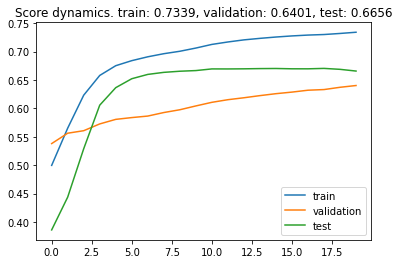

max_pooling test quality: 0.6655989880067208


In [24]:
max_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='max').to(device)
run(max_model, "max_pooling")

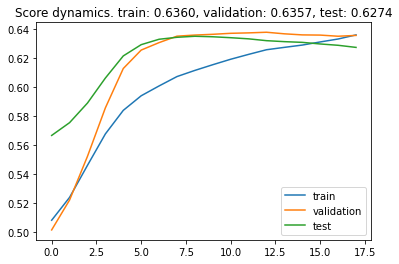

EarlyStopping counter: 5 out of 5
mean_pooling test quality: 0.6320496726472122


In [25]:
mean_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='mean').to(device)
run(mean_model, "mean_pooling")

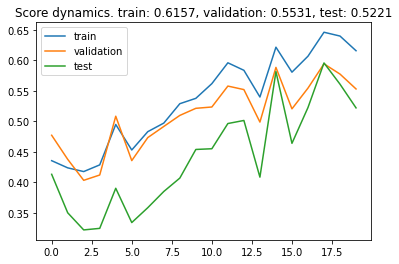

EarlyStopping counter: 2 out of 5
sum_pooling test quality: 0.5221267309140771


In [26]:
sum_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='sum').to(device)
run(sum_model, "sum_pooling")

### DeepSet pooling

The paper: https://arxiv.org/abs/1703.06114

Simple aggregation of set element embedding could produce the wrong whole graph embedding, because we try to aggregate continuously discrete structures. So, one of the methods to eliminate it is the Deep Sets.

Deep Sets employs an idea that feed-forward neural networks are the universal estimators. Authors proves the theorem that for working with permutation invariant aggregation (e.g. summation) we can use as following:

$$\text{DeepSetPooling} = \text{MLP}_\phi \left(\sum_{v\in N} \text{MLP}_\theta (h_v)\right)$$

In [28]:
class DeepSetPooling(nn.Module):
  def __init__(self, atom_dim=8, num_layers_deep_set=3, hidden_dim=8, num_out_layers=2, out_dim=1):
    super(DeepSetPooling, self).__init__()
    self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
    self.pooling_func = dgl.sum_nodes
    self.deepsets = [nn.Linear(atom_dim, hidden_dim)]
    for _ in range(num_layers_deep_set - 1):
      self.deepsets.append(nn.Linear(hidden_dim, hidden_dim))
    self.deepsets = nn.ModuleList(self.deepsets)
    self.out_layers = []
    for _ in range(num_out_layers - 1):
      self.out_layers.append(nn.Linear(hidden_dim, hidden_dim))
    self.out_layers.append(nn.Linear(hidden_dim, out_dim))
    self.out_layers = nn.ModuleList(self.out_layers)
  
  def forward(self, graph):
    graph.ndata['h'] = self.atom_encoder(graph.ndata["feat"])
    for fc in self.deepsets:
      graph.ndata['h'] = fc(graph.ndata['h'])
      graph.ndata['h'] = F.relu(graph.ndata['h'])
    graph_vec = self.pooling_func(graph, 'h')
    for fc in self.out_layers[:-1]:
      graph_vec = fc(graph_vec)
      graph_vec = F.relu(graph_vec)
    return self.out_layers[-1](graph_vec)

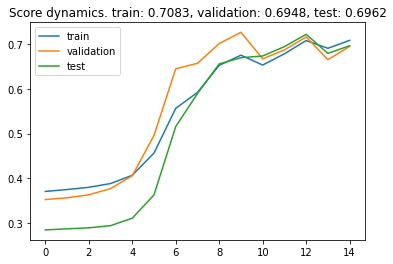

EarlyStopping counter: 5 out of 5
deepset_pooling test quality: 0.669372718669731


In [29]:
deepset_model = DeepSetPooling(out_dim=dataset.num_tasks).to(device)
run(deepset_model, "deepset_pooling")

### DiffPool for graph coarsening

The previous methods omit the graph structure because it simply pools the node embeddings.

To solve this issue, we will try technique named graph coarsening, specifically we will realised simplified version of the paper [Hierarchical Graph Representation Learning with Differentiable Pooling](https://arxiv.org/abs/1806.08804). It is an iterative procedure consisting of several steps:

1. Train GNN to predict node clusters (learn cluster assignment matrix $S$).

  In the step we simply apply GCN layer to our graph with feature projection to a lower dimension size. Then we normalize matrix with softmax over the feature dimension. Received matrix is the $S$.

2. Coarse the graph to the graph of clusters

  Calculate coarse adjacency matrix projecting original matrix with assignment one
$$A^\text{new} = S^\top A S$$
  Calculate the node level features with node embedding pooling
$$X^\text{new} = S^\top X$$
3. Repeat steps 1-2 several times
4. Use set polling technique to receive the graph embedding

Due to on-flight calculation of matrix $A^\text{new}$, it will be easier to work with GCN in vanilla way (project features with linear layer and then aggregate over the adjacency matrix).

Firstly, we will define an `DiffPoolLayer`

This layer realise the first two steps of the algorithm described above. More precisely, we can follow this steps to realise the `forward` method:

1. It takes adjacency matrix, node features and list with number of nodes in each batch.
2. Then it calculates the assign tensor with vanilla gcn: linear projection of hidden features, aggregation of features over the neighbours (matrix multiplication between adjacency and received feature projection)
3. Assign tensor is normalized with softmax over the feature dimension
4. Assign tensor is splitted into list of blocks based on number of nodes for each graph in batch
5. Splitted assign tensor is converted to the block diagonal matrix
6. Then it passes features through the GCN to receive new hidden representations of it.
7. New hidden features is calculated by matrix multiplication between assign matrix and features from 6
8. New adjacency matrix is calculated with projection by assign matrix
9. Return new adjacency and new features.

In [30]:
class DiffPoolLayer(nn.Module):
  def __init__(self, input_dim, assign_dim, out_feature_dim):
    super(DiffPoolLayer, self).__init__()
    self.feature_layer = nn.Sequential(
        nn.Linear(input_dim, out_feature_dim),
        nn.Linear(out_feature_dim, out_feature_dim)
    )
    self.pooling_layer = nn.Linear(input_dim, assign_dim)
  
  def gcn_with_adj(self, adj, h, layer):
    h = layer(h)
    return adj @ h / (adj.sum(dim=1, keepdims=True) + 1e-20)

  def forward(self, adj, h, batch_num_nodes):
    s = self.gcn_with_adj(adj, h, self.pooling_layer)
    s = F.softmax(s, dim=1)
    s = torch.split(s, batch_num_nodes)
    s = torch.block_diag(*s)
    f = self.gcn_with_adj(adj, h, self.feature_layer)
    f_new = s.t() @ f
    adj_new = s.t() @ adj @ s
    return adj_new, f_new

This layer will be used in the `DiffPool` neural network. Network iteratively coarse the graph using the `DiffPoolLayer` in `n_layers` coarsening steps and node number fall with `poolrate`.

1. Firstly, we extract the adjacency matrix and convert it to dense tensor
2. Extract `batch_num_nodes` into python list.
3. Encode atom features
4. Iterate over pooling layers
5. Take a mean of calculated vectors
6. Predict the label

In [31]:
class DiffPool(nn.Module):
  def __init__(self, atom_dim, hidden_dim, initial_assign_size=8, out_dim=1, n_layers=3, poolrate=0.5):
    super(DiffPool, self).__init__()
    self.poolrate = poolrate
    self.initial_assign_size = initial_assign_size
    self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
    self.atom_dim = atom_dim
    input_dim = atom_dim
    self.pool_layers = [DiffPoolLayer(input_dim, initial_assign_size, hidden_dim)]
    for _ in range(n_layers - 1):
      initial_assign_size = int(initial_assign_size * poolrate)
      self.pool_layers.append(DiffPoolLayer(hidden_dim, initial_assign_size, hidden_dim))
    self.pool_layers = nn.ModuleList(self.pool_layers)
    self.fc = nn.Linear(hidden_dim, out_dim)

  def forward(self, graph):
    adj = graph.adjacency_matrix(transpose=True, ctx=device)
    batch_num_nodes = graph.batch_num_nodes().tolist()
    h = self.atom_encoder(graph.ndata["feat"])
    sz = self.initial_assign_size
    adj = adj.to_dense()
    for i, layer in enumerate(self.pool_layers):
      adj, h = layer(adj, h, batch_num_nodes)
      batch_num_nodes = [sz] * graph.batch_size
      sz = int(sz * self.poolrate)
    h = dgl.ops.segment_reduce(torch.tensor(batch_num_nodes).to(device), h, 'mean')
    return self.fc(h)

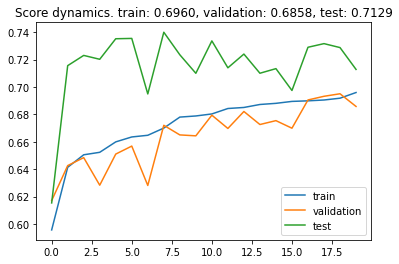

EarlyStopping counter: 1 out of 5
diffpool test quality: 0.71285270090191


In [32]:
diffpool_model = DiffPool(8, 8, 16, out_dim=dataset.num_tasks).to(device)
run(diffpool_model, "diffpool")